<a href="https://colab.research.google.com/github/vikramkrishnan9885/MyColab/blob/master/BinaryImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps (LEPBLOTD)

1. Load Data
2. Explore data
3. Preprocessing Data
4. Building the model
5. defining the Loss model
6. defining Optimizer
7. Train and evaluating the model
8. Deploying the model

# Fetch data

## From local

In [0]:
#from google.colab import files
#uploaded = files.upload()

## From kaggle
This did not work in our case because our data comes from a competition not a data set

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/My Drive/
%pwd

/content/drive/My Drive


'/content/drive/My Drive'

In [15]:
# Run the following code to provide the config path to kaggle.json
import os

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

#changing the working directory
#Check the present working directory using pwd command
%cd /content/drive/My Drive/Kaggle
%pwd

/content/drive/My Drive/Kaggle


'/content/drive/My Drive/Kaggle'

In [16]:
!kaggle datasets download -d datasnaek/youtube-new

youtube-new.zip: Skipping, found more recently modified local copy (use --force to force download)


## Using google drive

In [0]:
!unzip '/content/drive/My Drive/Kaggle/histopathologic-cancer-detection.zip'

# Explore data

In [0]:
import pandas as pd

## Read labels

First, we loaded the labels as a DataFrame using pandas. The DataFrame has two columns: id and label. The id column refers to the image filename, while the label column shows whether the image is normal (label=0) or malignant (label=1).

In [3]:
path2csv = 'train_labels.csv'
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Counts

In step 2, we counted the number of normal and malignant images. As we saw, around 59% of the images were normal and 41% were malignant. The histogram in step 3 shows somewhat imbalanced data.

In [4]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Histogram of labels

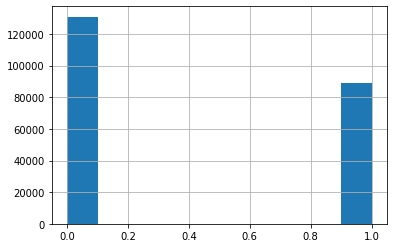

In [5]:
%matplotlib inline
labels_df['label'].hist()

## Let's visualize a few images that have a positive label. 

A positive label shows that the center 32 x 32 region of an image contains at least one pixel of tumor tissue.

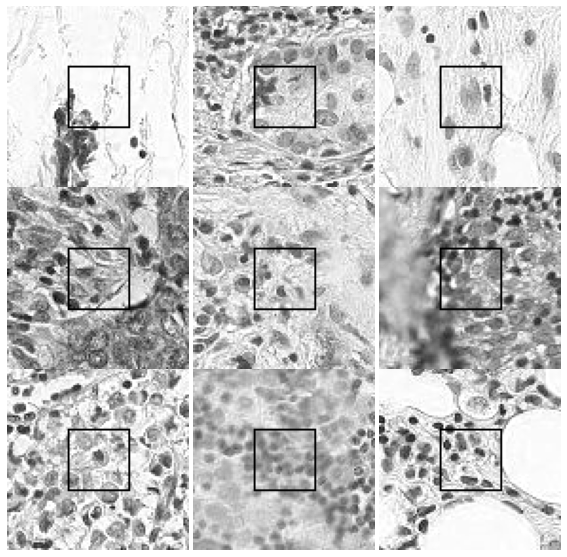

In [6]:
# First, we import the required packages:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

# data is stored here
path2train="train/"

# show images in gray-scale, if you want color change it to True
color=False

# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# Next, we set the figure sizes
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

# Next, we display the images
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")

    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [7]:
# Let's also get the image's shape and minimum and maximum pixel values
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


# Preprocessing data

## Creating a custom dataset

A traditional method for working with a dataset would be to load all images into NumPy arrays. Since we are dealing with a relatively large dataset, this would be a waste of our computer resources. If you are short on RAM, this would be impossible. Luckily, PyTorch has a powerful tool to handle large datasets.

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When creating a custom Dataset class, make sure to define two essential functions: `__len__` and `__getitem__`. The `__len__` function returns the dataset's length. This function is callable with the Python len function. The `__getitem__` function returns an image at the specified index.